# Interactive Langevin Thermostat
based on: https://github.com/pyiron/pyiron_contrib/blob/master/pyiron_contrib/protocol/primitive/one_state.py

In [1]:
%matplotlib inline

In [2]:
import numpy as np

In [3]:
import matplotlib.pyplot as plt

In [4]:
from pyiron import Project

In [5]:
from pyiron import Notebook as nb

In [6]:
from scipy.constants import physical_constants

# Parameter

In [7]:
temperature = 1000.0 
cell_size = 3
steps = 10000

# Project

In [8]:
pr = Project('md_' + str(temperature).replace('.', '_'))

In [9]:
pr.remove_jobs(recursive=True)

# Structure

In [10]:
basis = pr.create_structure('Fe', 'bcc', 2.78)

In [11]:
basis.set_repeat([cell_size, cell_size, cell_size])

In [12]:
len(basis)

54

# Equilibration - Lammps MD for comparison

In [13]:
ham_equ = pr.create_job(pr.job_type.Lammps, 'lmpequ')

In [14]:
ham_equ.structure = basis

In [15]:
ham_equ.potential = 'Fe_C_Hepburn_Ackland_eam'

In [16]:
ham_equ.calc_md(temperature=temperature, n_print=1, n_ionic_steps=steps, langevin=True)

In [17]:
ham_equ.run()

The job lmpequ was saved and received the ID: 1


In [18]:
ham_equ.decompress()

In [19]:
ham_equ['log.lammps'][-30:]

['    9998     847.997491942227    -207.010599031488    -201.201148256779     185466.318651657     7781.58756432837     4507.59691143553     189780.976571258     772.252624472177     179740.282052424           580.093704 \n',
 '    9999     872.578146241834    -207.066106672557    -201.088259054084     184560.069419709     7516.92844233291     4558.95679284193     190271.060110853     1208.43512474088     180292.048248569           580.093704 \n',
 '   10000     875.311933714808    -207.123851810011    -201.127275593985      183660.58727366     7175.63652020681     4849.60033286873     190245.733978111     1892.79912844875     180444.904187673           580.093704 \n',
 'Loop time of 5.51712 on 1 procs for 10000 steps with 54 atoms\n',
 '\n',
 'Performance: 156.603 ns/day, 0.153 hours/ns, 1812.540 timesteps/s\n',
 '91.3% CPU use with 1 MPI tasks x no OpenMP threads\n',
 '\n',
 'MPI task timing breakdown:\n',
 'Section |  min time  |  avg time  |  max time  |%varavg| %total\n',
 '------

# Interactive Job

## Constants

In [20]:
KB = physical_constants['Boltzmann constant in eV/K'][0]
EV_TO_U_ANGSQ_PER_FSSQ = physical_constants['Faraday constant'][0] / 10**7
U_ANGSQ_PER_FSSQ_TO_EV = 1. / EV_TO_U_ANGSQ_PER_FSSQ

In [21]:
overheat_fraction = 2.0
damping_timescale = 100.
time_step = 1

## Functions 
copied from: https://github.com/pyiron/pyiron_contrib/blob/master/pyiron_contrib/protocol/primitive/one_state.py

In [22]:
def langevin_delta_v(temperature, time_step, masses, damping_timescale, velocities):
    """
    Velocity changes due to the Langevin thermostat.
    Args:
        temperature (float): The target temperature in K.
        time_step (float): The MD time step in fs.
        masses (numpy.ndarray): Per-atom masses in u with a shape (N_atoms, 1).
        damping_timescale (float): The characteristic timescale of the thermostat in fs.
        velocities (numpy.ndarray): Per-atom velocities in angstrom/fs.
    Returns:
        (numpy.ndarray): Per atom accelerations to use for changing velocities.
    """
    drag = -0.5 * time_step * velocities / damping_timescale
    noise = np.sqrt(EV_TO_U_ANGSQ_PER_FSSQ * KB * temperature * time_step / (masses * damping_timescale)) \
        * np.random.randn(*velocities.shape)
    noise -= np.mean(noise, axis=0)
    return drag + noise

In [23]:
def convert_to_acceleration(forces, masses):
    return forces * EV_TO_U_ANGSQ_PER_FSSQ / masses

## Create Job

In [24]:
job_name = 'lmp_interactive'
ham_lmp = pr.create_job(pr.job_type.Lammps, job_name)
ham_lmp.structure = ham_equ.get_structure()
ham_lmp.potential = 'Fe_C_Hepburn_Ackland_eam'
ham_lmp.server.run_mode.interactive = True
ham_lmp.run()

The job lmp_interactive was saved and received the ID: 2


## Initial velocities

In [25]:
positions = ham_equ.get_structure().positions

In [26]:
masses = np.array([a.mass for a in ham_lmp.structure[:]])[:, np.newaxis]

In [27]:
forces = ham_lmp.output.forces[-1]

In [28]:
vel_scale = np.sqrt(EV_TO_U_ANGSQ_PER_FSSQ * KB * temperature / masses) * np.sqrt(overheat_fraction)
vel_dir = np.random.randn(len(masses), 3)
velocities = vel_scale * vel_dir
velocities -= np.mean(velocities, axis=0)

In [29]:
gamma = masses / damping_timescale

## Langevin 

In [30]:
eng_pot_lst, eng_kin_lst = [], []
for i in range(steps):
    # first half step
    acceleration = convert_to_acceleration(forces, masses)
    vel_half = velocities + 0.5 * acceleration * time_step
    
    # damping 
    if damping_timescale is not None:
        vel_half += langevin_delta_v(
            temperature,
            time_step,
            masses,
            damping_timescale,
            velocities
        )
    
    # postion update 
    pos_step = positions + vel_half * time_step
    
    # communicate with Lammps 
    positions = pos_step.copy()
    ham_lmp.interactive_positions_setter(pos_step)
    ham_lmp.interactive_execute()
    forces = np.array(ham_lmp.interactive_forces_getter())
    eng_pot_lst.append(ham_lmp.interactive_energy_pot_getter())
    
    # second half step 
    acceleration = convert_to_acceleration(forces, masses)
    vel_step = velocities + 0.5 * acceleration * time_step
    
    # damping 
    if damping_timescale is not None:
        vel_step += langevin_delta_v(
            temperature,
            time_step,
            masses,
            damping_timescale,
            velocities
        )
        
    # kinetic energy
    kinetic_energy = 0.5 * np.sum(masses * vel_step * vel_step) / EV_TO_U_ANGSQ_PER_FSSQ
    eng_kin_lst.append(kinetic_energy)
    velocities = vel_step.copy()

In [31]:
ham_lmp.interactive_close()

# Plot

In [32]:
pr.job_table()

,id,status,chemicalformula,job,subjob,projectpath,project,timestart,timestop,totalcputime,computer,hamilton,hamversion,parentid,masterid
0,1,finished,Fe54,lmpequ,/lmpequ,/home/jovyan/,md_1000_0/,2020-08-06 05:06:31.412944,2020-08-06 05:07:15.707079,44.0,pyiron@jupyter-jan-2djanssen-2dpyiron-2dmd-2dexample-2dsnmwe3w5#1,Lammps,0.1,None,None
1,2,finished,Fe54,lmp_interactive,/lmp_interactive,/home/jovyan/,md_1000_0/,2020-08-06 05:07:46.703938,2020-08-06 05:10:05.817111,139.0,pyiron@jupyter-jan-2djanssen-2dpyiron-2dmd-2dexample-2dsnmwe3w5#1,Lammps,0.1,None,None


Text(0, 0.5, 'Energy (eV)')

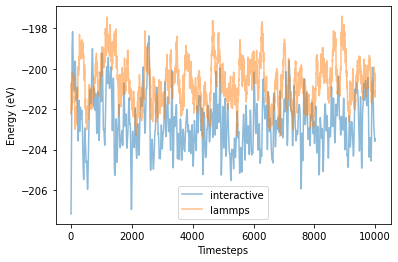

In [33]:
plt.plot(eng_pot_lst, alpha=0.5, label='interactive')
plt.plot(ham_equ['output/generic/energy_tot'], alpha=0.5, label='lammps')
plt.legend()
plt.xlabel('Timesteps')
plt.ylabel('Energy (eV)')